# Аналитика в Яндекс.Афише

Мы находимся на стажировке в отделе аналитики Яндекс.Афиши. Постараемся помочь маркетологам оптимизировать маркетинговые затраты. В нашем распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:

* лог сервера с данными о посещениях сайта Яндекс.Афиши;
* выгрузка всех заказов за этот период;
* статистика рекламных расходов.

В рамках проекта мы изучим:

* как люди пользуются продуктом;
* когда они начинают покупать;
* сколько денег приносит каждый клиент;
* когда клиент окупается.

### Описание данных

Наши данные хранятся в 3-х таблицах. Таблица visits (лог сервера с информацией о посещениях сайта) содержит:
* Uid — уникальный идентификатор пользователя;
* Device — категория устройства пользователя;
* Start Ts — дата и время начала сессии;
* End Ts — дата и время окончания сессии;
* Source Id — идентификатор рекламного источника, из которого пришел пользователь.

В таблице orders (информация о заказах) находятся:
* Uid — уникальный id пользователя, который сделал заказ;
* Buy Ts — дата и время заказа;
* Revenue — выручка Яндекс.Афиши с этого заказа.

В таблице costs содержится информация о затратах на маркетинг:
* source_id — идентификатор рекламного источника;
* dt — дата;
* costs — затраты на этот рекламный источник в этот день.

### Шаг 1. Загрузите данные и подготовьте их к анализу

Загрузим наши файлы и сохраним их в переменные.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import seaborn as sns
import math
import matplotlib.pyplot as plt

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

Посмотрим на данные в таблицах подробнее.

In [3]:
visits.head(10)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Видим, что в таблице `visits` 359400 строк и 5 столбцов. Пропусков в датафрейме нет, но есть ошибки в типах данных (столбцы End Ts и Start Ts). Приведём тип данных в них к `datetime`. Но для начала оптимизируем названия столбцов.

In [5]:
visits = visits.rename(columns={"Device": "device", "End Ts": "end_ts", "Source Id": "source_id", "Start Ts": "start_ts", "Uid": "uid"})
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [6]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y.%m.%d %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%Y.%m.%d %H:%M:%S')

In [7]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


Тип данных изменён. Посмотрим на таблицу `orders`. 

In [8]:
orders.head(10)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Здесь тоже нужно поменять имена столбцов, а один из них привести к типу данных `datetime`.

In [10]:
orders = orders.rename(columns={"Buy Ts": "buy_ts", "Revenue": "revenue", "Uid": "uid"})
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [11]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y.%m.%d %H:%M:%S')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


Получилось. Посмотрим на таблицу `costs`.

In [12]:
costs.head(10)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


In [13]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Здесь также нет пропусков, нужно уточнить название столбца `dt` и привести к корректному типу данных.


In [14]:
costs = costs.rename(columns={"dt": "date"})
costs['date'] = pd.to_datetime(costs['date'], format='%Y.%m.%d %H:%M:%S')
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
date         2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


Мы оптимизировали таблицы, теперь приступим к анализу и подсчёту метрик.

### Шаг 2. Постройте отчёты и посчитайте метрики

#### Продукт

Посмотрим, сколько людей пользуются Яндекс.Афишей в день, неделю, месяц. Для этого добавим в таблицу `visits` новые столбцы: `day`, `week`, `month`, `year`.

In [15]:
visits['day'] = visits['start_ts'].astype('datetime64[D]') 
visits['week'] = visits['start_ts'].astype('datetime64[W]')
visits['month'] = visits['start_ts'].astype('datetime64[M]')
visits['year'] = visits['start_ts'].astype('datetime64[Y]')

In [16]:
visits.head()

,device,end_ts,source_id,start_ts,uid,day,week,month,year
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,2017-01-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,2018-01-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,2017-01-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,2018-01-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01,2017-01-01


В столбце `day` хранится конкретная дата, в `week` - дата начала недели, в `month` - первый день месяца, в `year` - первый день года. Сгруппируем пользователей по дням и посмотрим, какое количество посещает сайт в день.

In [17]:
visits_daily = visits.groupby('day').agg({'uid': ['nunique']})
visits_daily.columns = ['unique_users']
visits_daily.head()

,unique_users
day,
2017-06-01,605
2017-06-02,608
2017-06-03,445
2017-06-04,476
2017-06-05,820


In [18]:
visits_daily['unique_users'].mean()

907.9917582417582

В среднем 908 уникальных пользователей в день. Построим график и посмотрим на распределение в течение года.

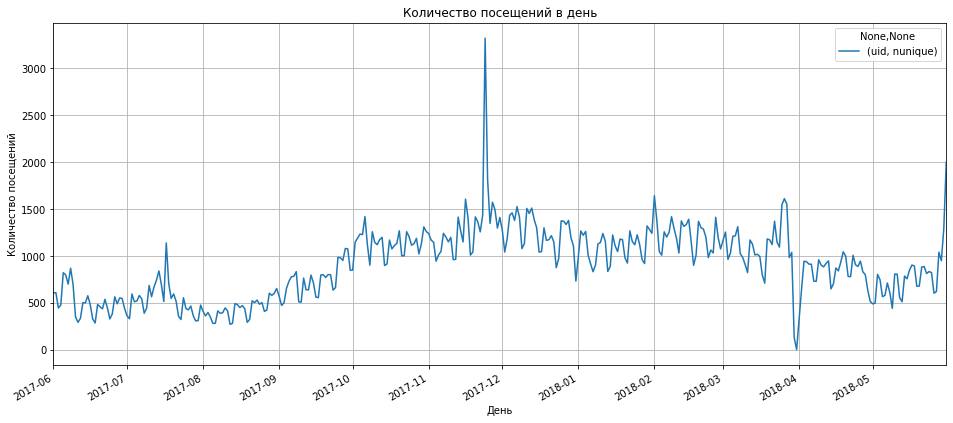

In [19]:
visits_daily = visits.groupby('day').agg({'uid': ['nunique']})
visits_daily.plot(grid=True, title='Количество посещений в день', figsize=(16, 7))
plt.gca().set(xlabel='День', ylabel='Количество посещений')
plt.show()

На графике можем отметить всплеск активности в середине июля (по сравнению со всеми летними месяцами), рост количества посещений с сентября, а также пик активности в конце ноября. Кроме того, в конце марта можем заметить аномальную просадку (возможно, были неполадки с сайтом).

Теперь посмотрим сколько пользователей посещает сайт в неделю. Для этого построим сводную таблицу с посещениями по неделям, затем посмотрим на среденее значение и построим график.

In [20]:
visits_weekly = visits.groupby('week').agg({'uid': ['nunique']})
visits_weekly.columns = ['unique_users']
visits_weekly.head()

,unique_users
week,
2017-06-01,4082
2017-06-08,3311
2017-06-15,2844
2017-06-22,3079
2017-06-29,3055


In [21]:
visits_weekly['unique_users'].mean()

5724.415094339623

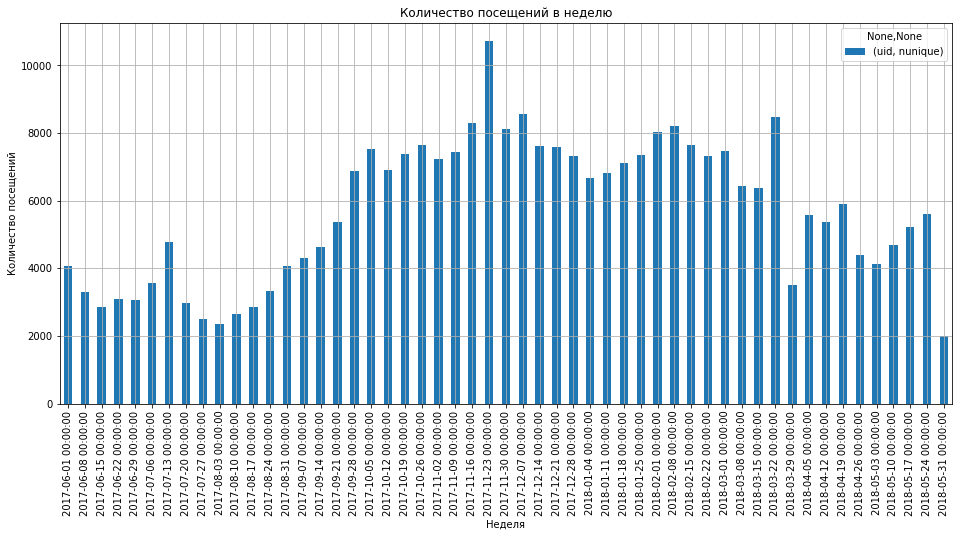

In [22]:
visits_weekly = visits.groupby('week').agg({'uid': ['nunique']})
visits_weekly.plot(kind='bar', grid=True, title='Количество посещений в неделю', figsize=(16, 7))
plt.gca().set(xlabel='Неделя', ylabel='Количество посещений')
plt.show()

Среднее количество посетителей в неделю составило 5724. Построим данные по месяцам.

In [23]:
visits_monthly = visits.groupby('month').agg({'uid': ['nunique']})
visits_monthly.columns = ['unique_users']
visits_monthly

,unique_users
month,
2017-06-01,13259
2017-07-01,14183
2017-08-01,11631
2017-09-01,18975
2017-10-01,29692
2017-11-01,32797
2017-12-01,31557
2018-01-01,28716
2018-02-01,28749


In [24]:
visits_monthly['unique_users'].mean()

23228.416666666668

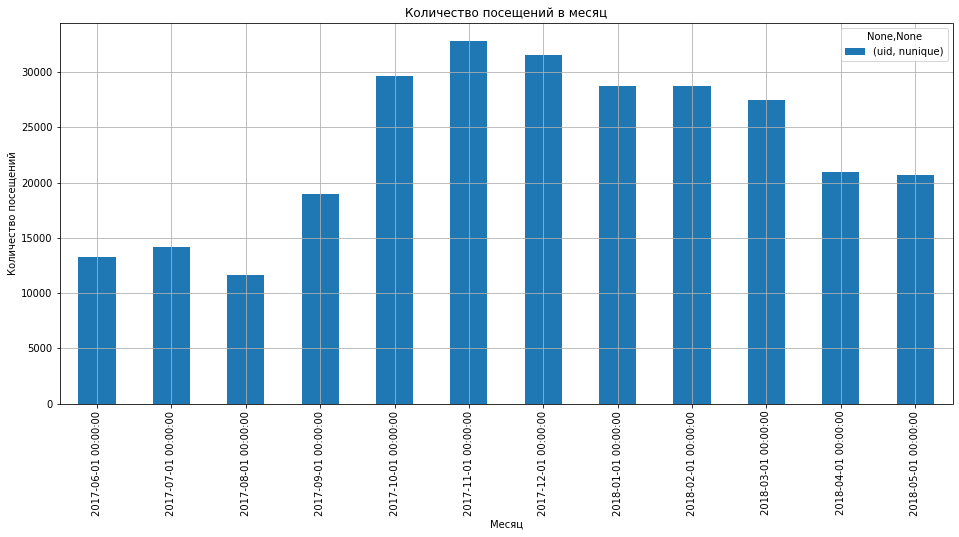

In [25]:
visits_monthly = visits.groupby('month').agg({'uid': ['nunique']})
visits_monthly.plot(kind='bar', grid=True, title='Количество посещений в месяц', figsize=(16, 7))
plt.gca().set(xlabel='Месяц', ylabel='Количество посещений')
plt.show()

23228 уникальных посетителей в месяц в среднем посетило Яндекс.Афишу за год. 

Посмотрим теперь количетсво уникальных посетителей в зависимости от источника трафика. 

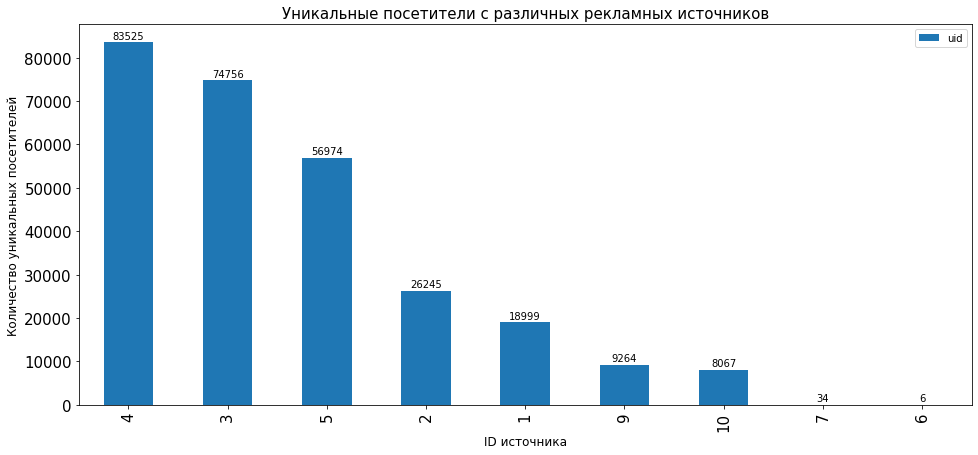

In [26]:
ax = (visits
             .pivot_table(index=['source_id'], aggfunc={'uid':'nunique'})
             .sort_values(by='uid', ascending=False)
             .plot(kind='bar', figsize=(16, 7), fontsize=15)
             )
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
                  height + 800,
                  '{:1.0f}'.format(height),
                  ha="center")
plt.title('Уникальные посетители с различных рекламных источников', fontsize=15)
plt.xlabel('ID источника', fontsize=12)
plt.ylabel('Количество уникальных посетителей', fontsize=12)
plt.show()

Узнаем, сколько сессий совершается в среднем за день. Для этого построим сводную таблицу с количеством сессий и количеством посетителей. После этого добавим столбец со средним количеством сессий по дням.

In [27]:
daily_user_sessions = visits.groupby('day').agg({'uid': ['count','nunique']})
daily_user_sessions.columns = ['sessions', 'users']
daily_user_sessions['sessions_per_user'] = daily_user_sessions['sessions'] / daily_user_sessions['users']
daily_user_sessions

,sessions,users,sessions_per_user
day,,,
2017-06-01,664,605,1.097521
2017-06-02,658,608,1.082237
2017-06-03,477,445,1.071910
2017-06-04,510,476,1.071429
2017-06-05,893,820,1.089024
...,...,...,...
2018-05-27,672,620,1.083871
2018-05-28,1156,1039,1.112608
2018-05-29,1035,948,1.091772


In [28]:
daily_user_sessions['sessions_per_user'].mean()

1.082169644003972

Видим, что пользователи крайне редко посещают сайт больше одного раза в день. Посмотрим, как часто это происходит за год.

In [29]:
year_user_sessions = visits.groupby('year').agg({'uid': ['count','nunique']})
year_user_sessions.columns = ['sessions', 'users']
year_user_sessions['sessions_per_user'] = year_user_sessions['sessions'] / year_user_sessions['users']
year_user_sessions

,sessions,users,sessions_per_user
year,,,
2017-01-01,196450,131777,1.490776
2018-01-01,162950,112535,1.447994


In [30]:
year_user_sessions['sessions_per_user'].mean()

1.4693850206370354

Видим, что в целом за год пользователь заходит на Яндекс.Афишу в среднем 1,47 раза.

Посмотрим, сколько длится одна сессия. Для начала добавим столбец с разницей межд началом и концом сессий.

In [31]:
visits['time_ses'] = visits['end_ts'] - visits['start_ts']
visits

,device,end_ts,source_id,start_ts,uid,day,week,month,year,time_ses
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,2017-01-01,00:18:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,2018-01-01,00:28:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,2017-01-01,00:00:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,2018-01-01,00:24:00
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01,2017-01-01,00:00:00
...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-29,2017-07-27,2017-07-01,2017-01-01,00:00:19
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-25,2018-01-25,2018-01-01,2018-01-01,00:00:19
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-03,2018-03-01,2018-03-01,2018-01-01,00:00:19
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-02,2017-11-02,2017-11-01,2017-01-01,00:00:19


Посмотрим на моду и медиану нового столбца `time_ses`.

In [32]:
visits['time_ses'].mode()

0   00:01:00
dtype: timedelta64[ns]

In [33]:
visits['time_ses'].median()

Timedelta('0 days 00:05:00')

Наиболее часто встречаемое значение - 1 минута. Половина пользователей задерживается на сайте не больше 5 минут.

Переведём столбец `time_ses` в секунды, а затем поменяем тип данных на `int`.

In [34]:
visits['time_ses'] = visits['time_ses'].dt.total_seconds()
visits

,device,end_ts,source_id,start_ts,uid,day,week,month,year,time_ses
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,2017-01-01,1080.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,2018-01-01,1680.0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,2017-01-01,0.0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,2018-01-01,1440.0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01,2017-01-01,0.0
...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-29,2017-07-27,2017-07-01,2017-01-01,19.0
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-25,2018-01-25,2018-01-01,2018-01-01,19.0
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-03,2018-03-01,2018-03-01,2018-01-01,19.0
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-02,2017-11-02,2017-11-01,2017-01-01,19.0


In [35]:
visits['time_ses'] = visits['time_ses'].astype('int')
visits.head()

,device,end_ts,source_id,start_ts,uid,day,week,month,year,time_ses
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,2017-01-01,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,2018-01-01,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,2017-01-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,2018-01-01,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01,2017-01-01,0


Посмотрим, сколько в среднем длится сессия в зависимости от месяца. Построим сводную таблицу, а затем построим график.

In [36]:
visits.pivot_table(index = 'month', values = 'time_ses', aggfunc = 'mean')

,time_ses
month,
2017-06-01,600.024114
2017-07-01,604.636246
2017-08-01,589.093905
2017-09-01,597.190446
2017-10-01,614.486083
2017-11-01,713.407605
2017-12-01,694.679632
2018-01-01,653.000054
2018-02-01,645.147168


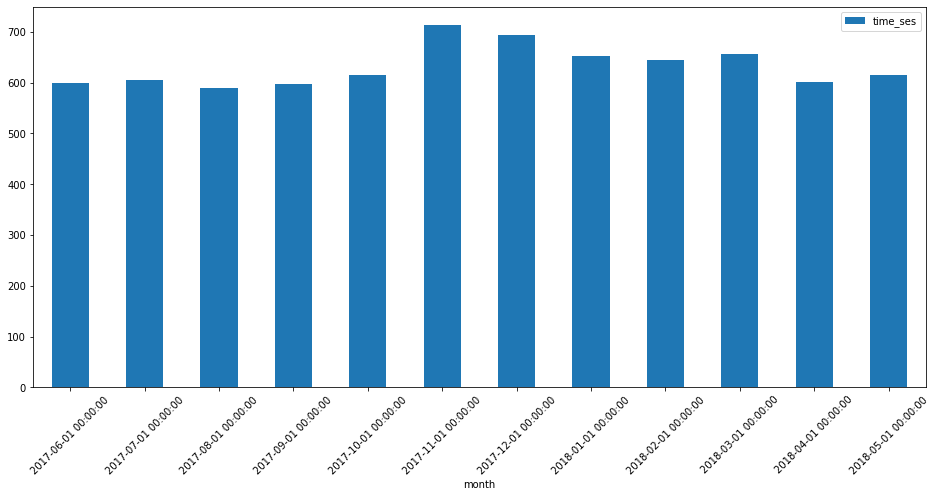

In [37]:
visits.pivot_table(index = 'month', values = 'time_ses', aggfunc = 'mean').plot(kind='bar', figsize=(16, 7), rot=45)
plt.show()

Видим, что в целом длительность сессий распределяется равномерно. Можно заметить, что с ноября по март она чуть выше, чем в остальные месяцы. 

Посмотрим, зависит ли длительность сессий в засимости от используемого девайса. Построим сводную таблицу.

In [38]:
visits.pivot_table(index = 'device', values = 'time_ses', aggfunc = 'mean')

,time_ses
device,
desktop,703.288860
touch,479.619407


Длительность заметно выше на десктопных версиях устройств.

Теперь посмотрим, как часто посетители возвращаются на сайт. Для начала сгруппируем данные по столбцу 'uid' методом groupby(). Для каждого клиента получим дату его первого заказа. Объеденим датафреймы `visits` и `first_activity_month` по столбцу `uid`; преобразуем значение столбца `first_activity_month` к типу `datetime64[M]` и выведем первые 5 строк.

In [39]:
first_activity_month = visits.groupby('uid')['start_ts'].min()
first_activity_month.name = 'first_activity_month'
visits = visits.join(first_activity_month,on='uid')
visits['first_activity_month'] = visits['first_activity_month'].astype('datetime64[M]')
visits.head()

,device,end_ts,source_id,start_ts,uid,day,week,month,year,time_ses,first_activity_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,2017-01-01,1080,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,2018-01-01,1680,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,2017-01-01,0,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,2018-01-01,1440,2018-03-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01,2017-01-01,0,2017-12-01


Сформируем когорты, сгруппировав пользователей по месяцу, когда впервые был посещён сайт.

In [40]:
visits.pivot_table(index='first_activity_month', columns='month', values='uid', aggfunc='nunique')

month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
first_activity_month,,,,,,,,,,,,
2017-06-01,13259.0,1043.0,713.0,814.0,909.0,947.0,809.0,766.0,694.0,674.0,539.0,596.0
2017-07-01,NaN,13140.0,737.0,674.0,738.0,765.0,633.0,596.0,601.0,510.0,376.0,361.0
2017-08-01,NaN,NaN,10181.0,783.0,640.0,639.0,510.0,448.0,370.0,402.0,284.0,265.0
2017-09-01,NaN,NaN,NaN,16704.0,1428.0,1156.0,847.0,658.0,632.0,599.0,404.0,381.0
2017-10-01,NaN,NaN,NaN,NaN,25977.0,2042.0,1357.0,1012.0,890.0,837.0,555.0,529.0
2017-11-01,NaN,NaN,NaN,NaN,NaN,27248.0,2133.0,1202.0,1054.0,919.0,638.0,594.0
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,25268.0,1410.0,960.0,786.0,512.0,481.0
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22624.0,1351.0,890.0,565.0,458.0
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22197.0,1267.0,565.0,446.0


По этой таблице можно сказать, что в каждой когорте с каждым месяцем число пользователей снижается. Найдём lifetime когорты. Для этого из месяца посощения сайта вычтем месяц когорты. Затем полученный столбец `cohort_lifetime` с типом `timedelta` преобразуем в число месяцев, прошедших между датами. Округлим значения в столбце и приведём данные к типу `int`.

In [41]:
visits['cohort_lifetime'] = visits['month'] - visits['first_activity_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')  
visits.head()

,device,end_ts,source_id,start_ts,uid,day,week,month,year,time_ses,first_activity_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,2017-01-01,1080,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,2018-01-01,1680,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,2017-01-01,0,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,2018-01-01,1440,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01,2017-01-01,0,2017-12-01,0


Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённый «месяц жизни».

In [42]:
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts.head()

,first_activity_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


Чтобы найти Retention Rate, нужно сперва получить число пользователей, изначально бывших в когорте, и на него разделить число пользователей в каждый следующий месяц. Найдём исходное количество пользователей в когорте. Возьмём их число на нулевой месяц.

In [43]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_users_count

,first_activity_month,uid
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


Методом `rename()` переименуем стольбец `uid` в `cohort_users`.

In [44]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

Объединим данные по когортам с исходным количеством пользователей в когорте.

In [45]:
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')

Теперь  рассчитаем `Retention Rate`. Разделим количество активных пользователей в каждый из месяцев на исходное число пользователей в когорте.

In [46]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] 

Построим сводную таблицу и тепловую карту.

In [47]:
retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


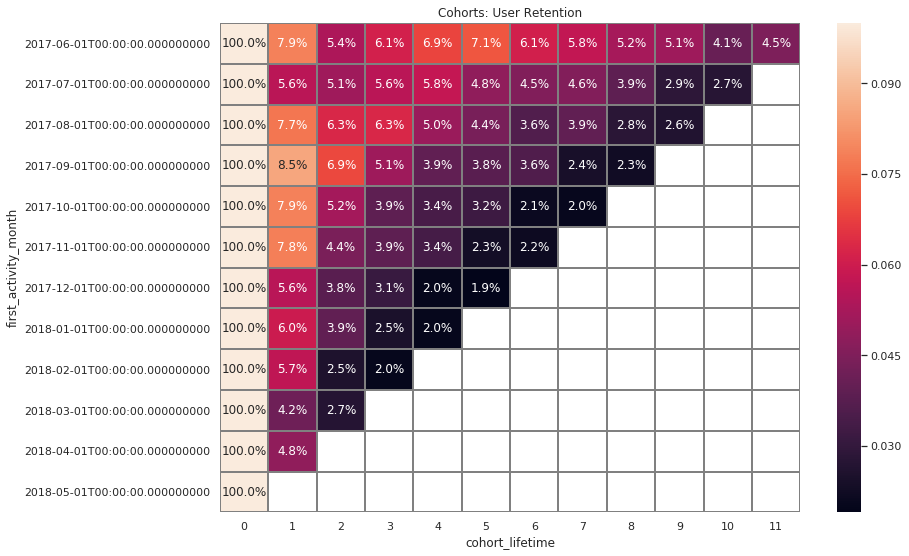

In [48]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmax=0.1);

Мы видим, что во всех когортах с каждым месяцем процент пользователей снижается (только в июньской и в июльской есть небольшие колебания вверх, но в целом динамика такая же). Это логично, учитывая специфику сервиса: такими сервисами люди пользуются скорее ситуативно, нежели по привычке, поэтому `retention`, стремящегося к 100% мы здесь изначально не ожидали. 

#### Продажи

В этом пункте перед нами стоят следующие вопросы:

* когда люди начинают покупать?
* сколько раз покупают за период?
* какой средний чек?
* сколько денег приносят? (LTV)

Для ответа на первый вопрос нам нужно посмотреть на разницу между первой покупкой и первым визитом. Добавим в таблицу `visits` дату первого визита. 

In [49]:
session_date = visits.groupby('uid')['start_ts'].min()
session_date.name = 'session_date'
visits = visits.join(session_date,on='uid')
visits['session_date'] = visits['session_date'].astype('datetime64[D]')
visits.head()

,device,end_ts,source_id,start_ts,uid,day,week,month,year,time_ses,first_activity_month,cohort_lifetime,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,2017-01-01,1080,2017-12-01,0,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,2018-01-01,1680,2018-02-01,0,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,2017-01-01,0,2017-07-01,0,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,2018-01-01,1440,2018-03-01,2,2018-03-09
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01,2017-01-01,0,2017-12-01,0,2017-12-27


Добавим дату первой покупки для каждого пользователя в таблице `orders`, а затем соеденим обе таблице по `uid`.

In [50]:
first_purchase = orders.groupby('uid')['buy_ts'].min()
first_purchase.name = 'first_purchase'
orders = orders.join(first_purchase,on='uid')
orders['first_purchase'] = orders['first_purchase'].astype('datetime64[D]')
orders.head()

,buy_ts,revenue,uid,first_purchase
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01


In [51]:
visits = visits.merge(orders, on='uid', how='left')
visits.head()

,device,end_ts,source_id,start_ts,uid,day,week,month,year,time_ses,first_activity_month,cohort_lifetime,session_date,buy_ts,revenue,first_purchase
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,2017-01-01,1080,2017-12-01,0,2017-12-20,NaT,NaN,NaT
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,2018-01-01,1680,2018-02-01,0,2018-02-19,NaT,NaN,NaT
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,2017-01-01,0,2017-07-01,0,2017-07-01,NaT,NaN,NaT
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,2018-01-01,1440,2018-03-01,2,2018-03-09,2018-03-09 20:25:00,2.33,2018-03-09
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01,2017-01-01,0,2017-12-01,0,2017-12-27,NaT,NaN,NaT


Теперь вычтем из первого дня заказа первый день визита.

In [52]:
visits['days_to_purchase'] = visits['first_purchase'] - visits['session_date']
visits.head()

,device,end_ts,source_id,start_ts,uid,day,week,month,year,time_ses,first_activity_month,cohort_lifetime,session_date,buy_ts,revenue,first_purchase,days_to_purchase
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,2017-01-01,1080,2017-12-01,0,2017-12-20,NaT,NaN,NaT,NaT
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,2018-01-01,1680,2018-02-01,0,2018-02-19,NaT,NaN,NaT,NaT
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,2017-01-01,0,2017-07-01,0,2017-07-01,NaT,NaN,NaT,NaT
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,2018-01-01,1440,2018-03-01,2,2018-03-09,2018-03-09 20:25:00,2.33,2018-03-09,0 days
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01,2017-01-01,0,2017-12-01,0,2017-12-27,NaT,NaN,NaT,NaT


In [53]:
visits['days_to_purchase'].describe()

count                     761807
mean     17 days 15:03:06.524408
std      42 days 09:50:51.736595
min              0 days 00:00:00
25%              0 days 00:00:00
50%              2 days 00:00:00
75%              9 days 00:00:00
max            363 days 00:00:00
Name: days_to_purchase, dtype: object

Видим, что в среднем 17 дней уходит у пользователей на совершение покупки. Однако здесь лучше отталкиваться от медианого значения: у половины пользователей, совершивших покупку, уходит на это до 2-х дней, а у 75% пользователей на покупку уходит до 9 дней. Также посмотрим на моду.

In [54]:
visits['days_to_purchase'].mode()

0   0 days
dtype: timedelta64[ns]

Это говорит нам о том, что покупку чаще всего совершают в день первого визита. Теперь посмотрим сколько раз пользователи покупают за период. Добавим в таблицу `orders` столбцы `day`, `week` и `month`.

In [55]:
orders['day'] = orders['buy_ts'].astype('datetime64[D]') 
orders['week'] = orders['buy_ts'].astype('datetime64[W]')
orders['month'] = orders['buy_ts'].astype('datetime64[M]')

Построим графики распределения заказов на Яндекс.Афише по дням, неделям и месяцам.

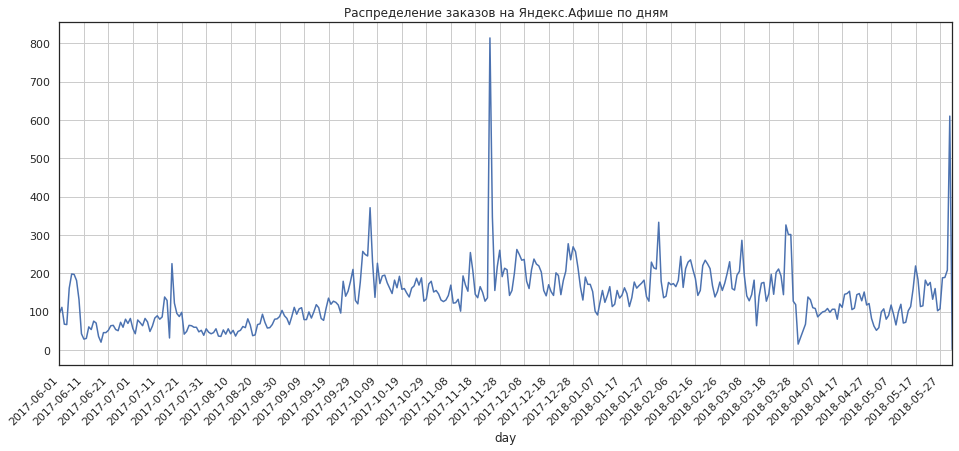

In [56]:
orders.groupby('day')['uid'].count()\
.plot(title='Распределение заказов на Яндекс.Афише по дням', figsize=(16,7), grid=True)
plt.xticks(np.arange(orders['day'].min(),orders['day'].max() + pd.to_timedelta('1 day'),pd.to_timedelta('10 day')),rotation = 45)
plt.show()

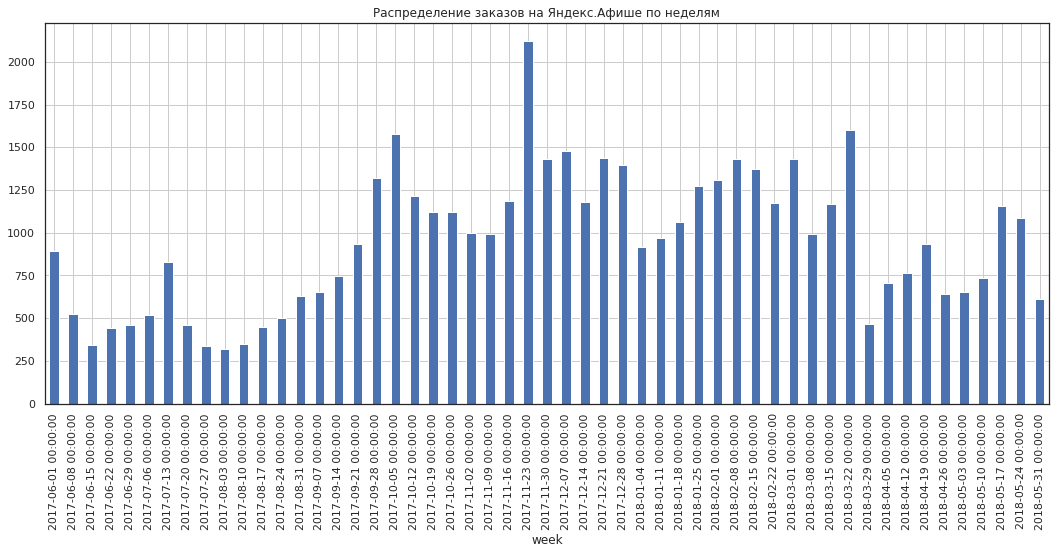

In [57]:
orders.groupby('week')['uid'].count()\
.plot(kind='bar', title='Распределение заказов на Яндекс.Афише по неделям', figsize=(18,7), grid=True)
plt.show()

In [58]:
orders.pivot_table(index = 'month', values = 'uid', aggfunc = 'count')

,uid
month,
2017-06-01,2354
2017-07-01,2363
2017-08-01,1807
2017-09-01,3387
2017-10-01,5679
2017-11-01,5659
2017-12-01,6218
2018-01-01,4721
2018-02-01,5281


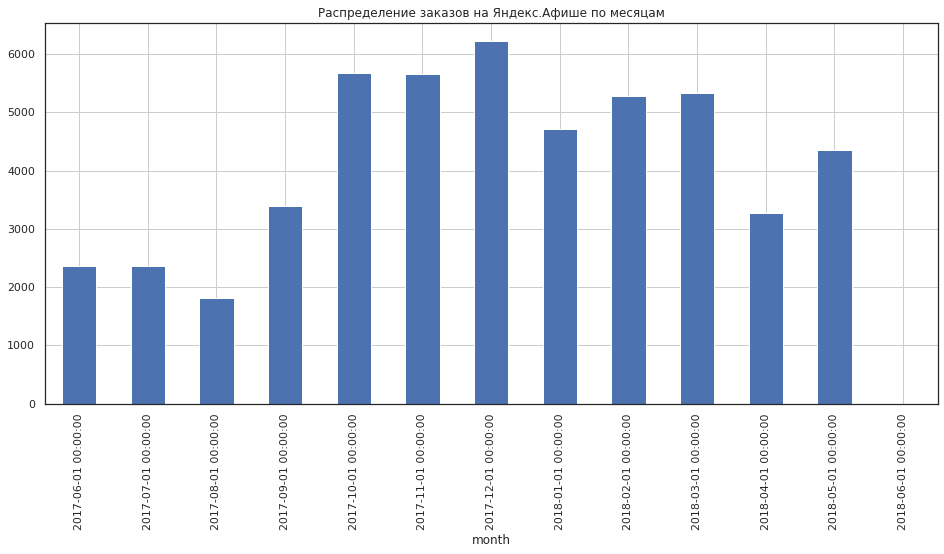

In [59]:
orders.groupby('month')['uid'].count()\
.plot(kind='bar', title='Распределение заказов на Яндекс.Афише по месяцам', figsize=(16,7), grid=True)
plt.show()

Видим, что ситуация, как и с посещениями сайта: в летние месяцы было сделано меньше всего покупок (в августе зафиксирован минимум - 1807), а с октября по ноябрьбольше всего (пик пришёлся на декабрь - 6218).

Посчитаем средний чек. Для этого построим сводную таблицу с количеством заказов и суммой выручки, сгруппировав по дням. Затем разделим сумму выручки на количество заказов  и получим столбец со средним чеком по дням.

In [60]:
orders_new = orders.groupby('day').agg({'uid': 'count', 'revenue': 'sum'})
orders_new['av_check'] = orders_new['revenue'] / orders_new['uid']
orders_new

,uid,revenue,av_check
day,,,
2017-06-01,96,389.46,4.056875
2017-06-02,111,324.11,2.919910
2017-06-03,67,166.48,2.484776
2017-06-04,66,195.21,2.957727
2017-06-05,161,441.49,2.742174
...,...,...,...
2018-05-28,188,740.00,3.936170
2018-05-29,189,491.06,2.598201
2018-05-30,208,1021.69,4.911971


Посмотрим какая в среднем выручка по дням.

In [61]:
orders_new['av_check'].describe()

count    364.000000
mean       4.936188
std        2.021881
min        1.948000
25%        3.960635
50%        4.561548
75%        5.411037
max       29.133313
Name: av_check, dtype: float64

Выручка в среднем составила около 4.9, а 75% клиентов заплатили менее 5.5. Посмотрим на динамику среднего чека в течение года.

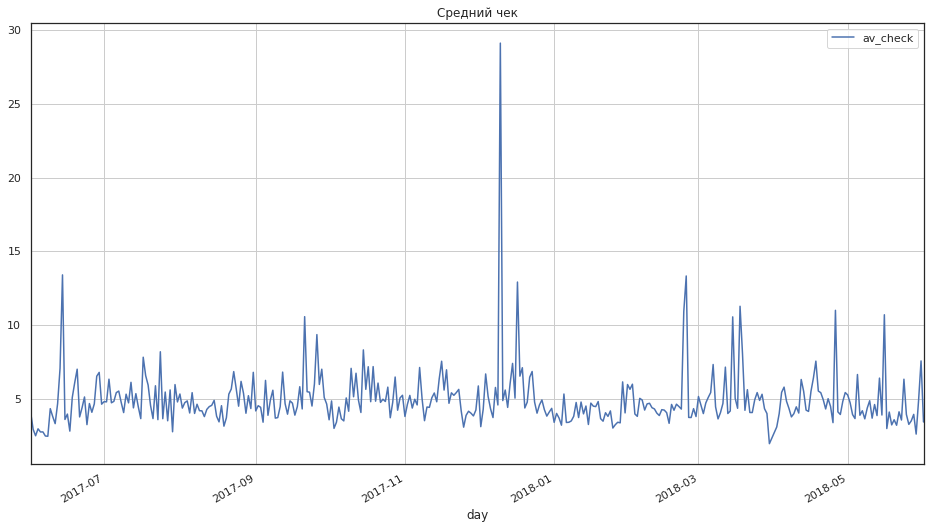

In [62]:
orders_new.pivot_table(index='day', values='av_check', aggfunc='sum').plot(figsize=(16, 9), grid=True)
plt.title('Средний чек')
plt.show()

Роста или уменьшения мы не наблюдаем, можно отметить несколько скачков свыше 10 в разное время года, а также огромный скачок в декабре: тогда средний чек поднялся до 29.

Посмотрим сколько денег приносят люди и посчитаем LTV. Посмотрим ещё раз на таблицу с информацией о заказах, а затем посмотрим на распределение дат заказов.

In [63]:
orders.head()

,buy_ts,revenue,uid,first_purchase,day,week,month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,2017-06-01


In [64]:
orders['buy_ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

Виим, что первая покупка состоялась 1 июня 2017 года, а последняя 1 июня 2018 года. Посмотрим файл с расходами и на распределение дат.

In [65]:
costs.head()

,source_id,date,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [66]:
costs['date'].describe()

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: date, dtype: object

Диапазон дат расходов практически совпадает с датами заказов. LTV удобно считать по когортам. В таблице `orders`  у нас уже есть столбец с месяцем, чтобы выделить месячные когорты. Добавим столбец `month` в таблицу `costs`.

In [67]:
costs['month'] = costs['date'].astype('datetime64[M]')
costs.head()

,source_id,date,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


Получим месяц первой покупки каждого покупателя.

In [68]:
first_orders = orders.groupby('uid').agg({'month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
first_orders.head()

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


Посчитаем количество новых покупателей `n_buyers` за каждый месяц.

In [69]:
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


 Добавим месяц первой покупки каждого покупателя в таблицу с заказами.

In [70]:
orders = orders.merge(first_orders, on='uid', how='left')
orders.head()

,buy_ts,revenue,uid,first_purchase,day,week,month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01


Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку.

In [71]:
cohorts_ltv = orders.groupby(['first_order_month','month']).agg({'revenue': 'sum'}).reset_index()
cohorts_ltv.head()

,first_order_month,month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


Строка таблицы cohorts показывает, какую выручку принесла когорта. Например, строка 0 сообщает, что покупатели, сделавшие свой первый заказ в июне 2017 года, в этом же месяце принесли суммарно 9557.49 выручки. Добавим в таблицу `cohorts` данные о том, сколько людей первый раз совершили покупку в каждый месяц.

In [72]:
report = cohort_sizes.merge(cohorts_ltv, on='first_order_month', how='left')
report.head()

,first_order_month,n_buyers,month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


В первых 5 строках значение столбца `n_buyers` не изменяется — это продажи одной и той же когорты. Вообще LTV считают не из выручки, а из валовой прибыли. Но так как `margin_rate` (маржинальность) нам не задан, то примем его за единицу и в этом проекте посчитаем LTV от выручки. Кроме того,  LTV — относительный показатель. Значит, его удобнее смотреть по «возрастным» когортам, где в столбцах — не месяц заказа, а возраст когорты. Добавим столбец `age` в таблицу `report`. 

In [73]:
report['age'] = (report['month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report.head()

,first_order_month,n_buyers,month,revenue,age
0,2017-06-01,2023,2017-06-01,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,4


Теперь найдём LTV. Разделим выручку когорт за каждый месяц на общее число пользователей в каждой когорте. Затем построим сводную таблицу с когортами.

In [74]:
report['ltv'] = report['revenue'] / report['n_buyers']
ltv = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean').round(2).cumsum(axis = 1)
ltv

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.44,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.40,NaN
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.37,7.58,7.99,8.28,8.47,NaN,NaN
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.43,NaN,NaN,NaN
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,NaN,NaN,NaN,NaN
2017-11-01,5.15,5.55,5.75,6.07,6.22,6.27,6.38,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.74,5.00,5.93,7.00,7.31,7.65,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.14,4.43,4.73,4.87,4.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.16,4.44,4.52,4.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Отобразим таблицу с помощью `heatmap`.

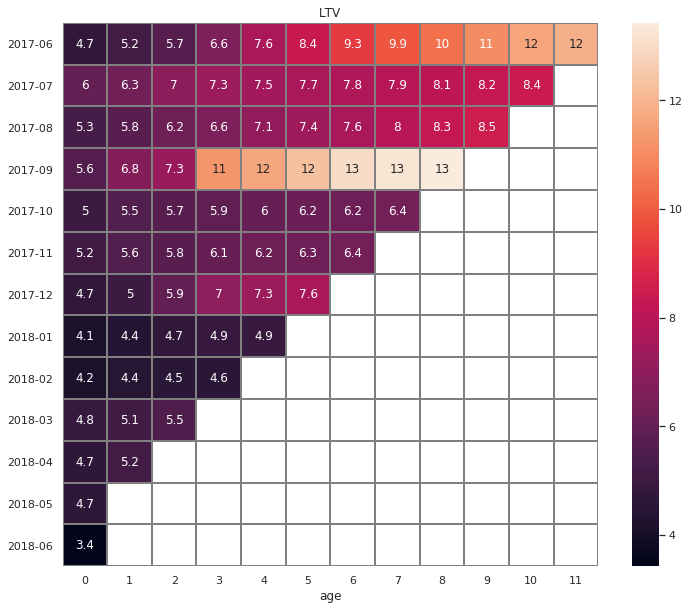

In [75]:
ltv.index = ltv.index.strftime('%Y-%m')
sns.set(style='white')
plt.figure(figsize=(12,10))
plt.title('LTV')
sns.heatmap(ltv, annot=True, linewidths=1, linecolor='gray')
plt.show()

Самый высокий `LTV` оказался у сентябрьской когорты (2017 года), на втором месте - июньская когорта того же года. Худший показатель у февральской, майской и январской когорт 2018 года (4.6, 4.7, 4.9 соответственно).

#### Маркетинг

Посчитаем сколько денег потратили на маркетинг всего, на каждый источник и по времени.

Для начала посмотрим, сколько денег было потрачено всего. Для этого просуммируем столбец `costs`. 

In [76]:
costs['costs'].sum()

329131.62

329131.62 - такая сумма была потрачена с июня 2017 года по май 2018 года. Посмотрим, как эти расходы распределились по источникам трафика. Для этого построим сводную таблицу.

In [77]:
costs.pivot_table(index='source_id', values='costs', aggfunc='sum').sort_values(by='costs', ascending=False)

,costs
source_id,
3,141321.63
4,61073.60
5,51757.10
2,42806.04
1,20833.27
10,5822.49
9,5517.49


Отобразим данные с помощью графика.

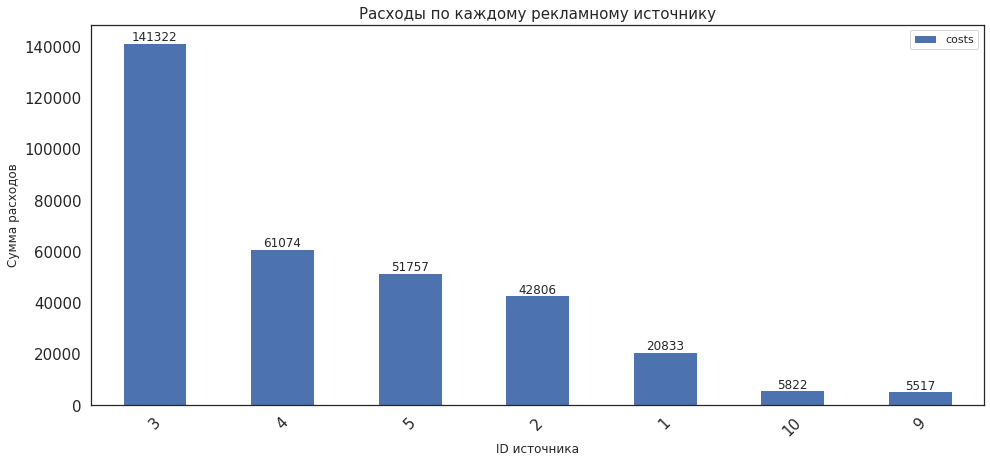

In [78]:
ax = (costs
             .pivot_table(index=['source_id'], aggfunc={'costs':'sum'})
             .sort_values(by='costs', ascending=False)
             .plot(kind='bar', figsize=(16, 7), fontsize=15, rot=45)
             )
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
                  height + 800,
                  '{:1.0f}'.format(height),
                  ha="center")
plt.title('Расходы по каждому рекламному источнику', fontsize=15)
plt.xlabel('ID источника', fontsize=12)
plt.ylabel('Сумма расходов', fontsize=12)
plt.show()

Видим, что на рекламный источник 3 израсходавана почти половина всей суммы. Источники 4, 5 и 2 вместе также составляют почти половину от всех расходов.

Посмотрим, как распределились расходы по месяцам. Построим сводную таблицу и отобразим результат на графике.

In [79]:
costs.pivot_table(index='month', values='costs', aggfunc='sum').sort_values(by='costs', ascending=False)

,costs
month,
2017-12-01,38315.35
2017-11-01,37907.88
2017-10-01,36322.88
2018-01-01,33518.52
2018-02-01,32723.03
2018-03-01,30415.27
2017-09-01,24368.91
2018-04-01,22289.38
2018-05-01,22224.27


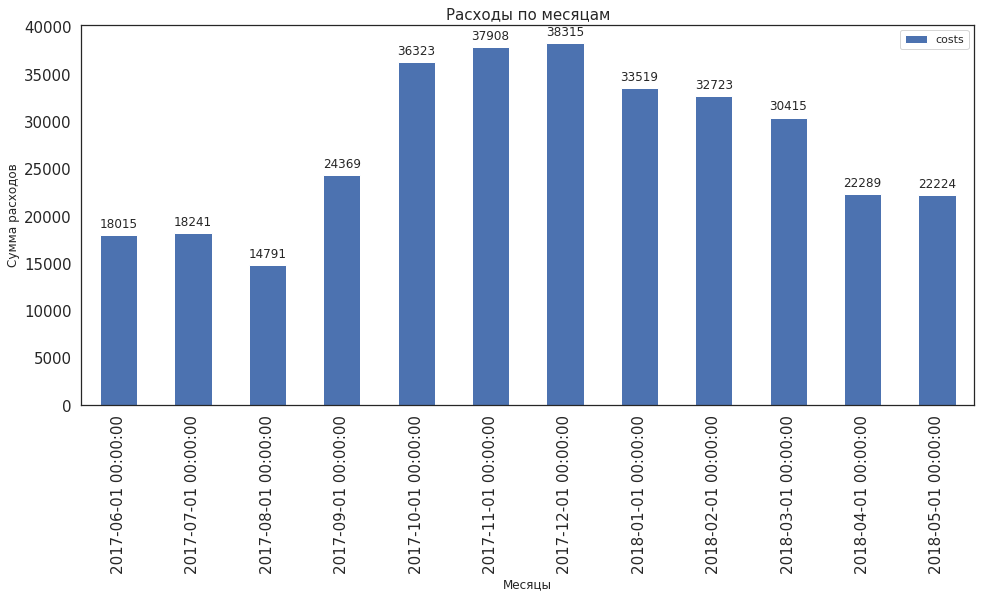

In [80]:
ax = (costs
             .pivot_table(index=['month'], aggfunc={'costs':'sum'})
             .plot(kind='bar', figsize=(16, 7), fontsize=15)
             )
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
                  height + 800,
                  '{:1.0f}'.format(height),
                  ha="center")
plt.title('Расходы по месяцам', fontsize=15)
plt.xlabel('Месяцы', fontsize=12)
plt.ylabel('Сумма расходов', fontsize=12)
plt.show()

Лидируют по расходам зимние и осенние месяцы. А расходы за все 3 летних месяца в сумме не превышают показатель абсолютного лидера - декабря.

Теперь посчитаем сколько стоило привлечение одного покупателя из каждого источника (CAC) и на сколько окупились расходы (ROI).

Вычислим первый источник для пользователя по таблице `visits`. 

In [81]:
first_activity_source = visits.sort_values(by='start_ts').groupby(['uid'])['source_id'].first()
first_activity_source.name = 'first_activity_source'
first_activity_source

uid
11863502262781          3
49537067089222          2
297729379853735         3
313578113262317         2
325320750514679         5
                       ..
18446403737806311543    5
18446424184725333426    4
18446556406699109058    3
18446621818809592527    4
18446676030785672386    3
Name: first_activity_source, Length: 228169, dtype: int64

Присоеденим таблицу `first_activity_source` к `orders` по `uid`.

In [82]:
orders = orders.merge(first_activity_source, on='uid', how='left')
orders

,buy_ts,revenue,uid,first_purchase,day,week,month,first_order_month,first_activity_source
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01,3
...,...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31,2018-05-31,2018-05-31,2018-05-01,2018-05-01,4
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31,2018-05-31,2018-05-31,2018-05-01,2018-05-01,10
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31,2018-05-31,2018-05-31,2018-05-01,2018-05-01,3
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31,2018-05-31,2018-05-31,2018-05-01,2018-05-01,3


Сгруппируем табличку `orders` по месяцу первой покупки и источнику, найдём количество людей в когортах.

In [83]:
orders_new1 = orders.groupby(['first_order_month','first_activity_source']).agg({'uid': 'nunique'}).reset_index()
orders_new1.head()

,first_order_month,first_activity_source,uid
0,2017-06-01,1,190
1,2017-06-01,2,235
2,2017-06-01,3,638
3,2017-06-01,4,413
4,2017-06-01,5,384


Сгруппируем табличку `orders` по месяцу первой покупки, текущему месяцу, источнику. Просуммируем `revenue`.

In [84]:
orders_new2 = orders.groupby(['first_order_month', 'month', 'first_activity_source']).agg({'revenue': 'sum'}).reset_index()
orders_new2.head()

,first_order_month,month,first_activity_source,revenue
0,2017-06-01,2017-06-01,1,1378.70
1,2017-06-01,2017-06-01,2,1043.68
2,2017-06-01,2017-06-01,3,2804.34
3,2017-06-01,2017-06-01,4,1959.84
4,2017-06-01,2017-06-01,5,1898.89


Объединим по месяцу первой покупки и источнику таблицы `orders_new1` и `orders_new2`.

In [85]:
report_new = orders_new1.merge(orders_new2, on=['first_order_month', 'first_activity_source'], how='inner')
report_new.columns = ['first_order_month', 'first_activity_source', 'n_buyers', 'month', 'revenue']
report_new

,first_order_month,first_activity_source,n_buyers,month,revenue
0,2017-06-01,1,190,2017-06-01,1378.70
1,2017-06-01,1,190,2017-07-01,414.98
2,2017-06-01,1,190,2017-08-01,419.43
3,2017-06-01,1,190,2017-09-01,714.24
4,2017-06-01,1,190,2017-10-01,811.20
...,...,...,...,...,...
511,2018-05-01,4,804,2018-05-01,3802.91
512,2018-05-01,5,497,2018-05-01,2094.04
513,2018-05-01,9,60,2018-05-01,223.05
514,2018-05-01,10,130,2018-05-01,470.89


Вычислим возраст когорт.

In [86]:
report_new['age'] = (report_new['month'] - report_new['first_order_month']) / np.timedelta64(1, 'M')
report_new['age'] = report_new['age'].round().astype('int')
report_new.head()

,first_order_month,first_activity_source,n_buyers,month,revenue,age
0,2017-06-01,1,190,2017-06-01,1378.70,0
1,2017-06-01,1,190,2017-07-01,414.98,1
2,2017-06-01,1,190,2017-08-01,419.43,2
3,2017-06-01,1,190,2017-09-01,714.24,3
4,2017-06-01,1,190,2017-10-01,811.20,4


Посчитаем LTV. Для этого разделим выручку на количество пользователей (помним, что `margin_rate` нам не задан, и мы принимаем его за 1).

In [87]:
report_new['ltv'] = report_new['revenue'] / report_new['n_buyers']
report_new.head()

,first_order_month,first_activity_source,n_buyers,month,revenue,age,ltv
0,2017-06-01,1,190,2017-06-01,1378.70,0,7.256316
1,2017-06-01,1,190,2017-07-01,414.98,1,2.184105
2,2017-06-01,1,190,2017-08-01,419.43,2,2.207526
3,2017-06-01,1,190,2017-09-01,714.24,3,3.759158
4,2017-06-01,1,190,2017-10-01,811.20,4,4.269474


Сгруппируем таблицу `costs` по источнику и месяцу.

In [88]:
costs_new = costs.groupby(['source_id','month']).agg({'costs': 'sum'}).reset_index()
costs_new.head()

,source_id,month,costs
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75


Присоединим получившуюся таблицу к `report_new` по месяцу и источнику.

In [89]:
report_new = pd.merge(report_new, costs_new, left_on=['first_order_month', 'first_activity_source'], right_on= ['month', 'source_id'])
report_new.head()

,first_order_month,first_activity_source,n_buyers,month_x,revenue,age,ltv,source_id,month_y,costs
0,2017-06-01,1,190,2017-06-01,1378.70,0,7.256316,1,2017-06-01,1125.61
1,2017-06-01,1,190,2017-07-01,414.98,1,2.184105,1,2017-06-01,1125.61
2,2017-06-01,1,190,2017-08-01,419.43,2,2.207526,1,2017-06-01,1125.61
3,2017-06-01,1,190,2017-09-01,714.24,3,3.759158,1,2017-06-01,1125.61
4,2017-06-01,1,190,2017-10-01,811.20,4,4.269474,1,2017-06-01,1125.61


Посчитаем CAC, поделив затраты на количесвто покупателей.

In [90]:
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new.head()

,first_order_month,first_activity_source,n_buyers,month_x,revenue,age,ltv,source_id,month_y,costs,cac
0,2017-06-01,1,190,2017-06-01,1378.70,0,7.256316,1,2017-06-01,1125.61,5.924263
1,2017-06-01,1,190,2017-07-01,414.98,1,2.184105,1,2017-06-01,1125.61,5.924263
2,2017-06-01,1,190,2017-08-01,419.43,2,2.207526,1,2017-06-01,1125.61,5.924263
3,2017-06-01,1,190,2017-09-01,714.24,3,3.759158,1,2017-06-01,1125.61,5.924263
4,2017-06-01,1,190,2017-10-01,811.20,4,4.269474,1,2017-06-01,1125.61,5.924263


Посчитаем ROI, поделив LTV на CAC.

In [91]:
report_new['roi'] = report_new['ltv'] / report_new['cac']
report_new.head()

,first_order_month,first_activity_source,n_buyers,month_x,revenue,age,ltv,source_id,month_y,costs,cac,roi
0,2017-06-01,1,190,2017-06-01,1378.70,0,7.256316,1,2017-06-01,1125.61,5.924263,1.224847
1,2017-06-01,1,190,2017-07-01,414.98,1,2.184105,1,2017-06-01,1125.61,5.924263,0.368671
2,2017-06-01,1,190,2017-08-01,419.43,2,2.207526,1,2017-06-01,1125.61,5.924263,0.372625
3,2017-06-01,1,190,2017-09-01,714.24,3,3.759158,1,2017-06-01,1125.61,5.924263,0.634536
4,2017-06-01,1,190,2017-10-01,811.20,4,4.269474,1,2017-06-01,1125.61,5.924263,0.720676


Построим график динамики CAC по источникам и месяцам.

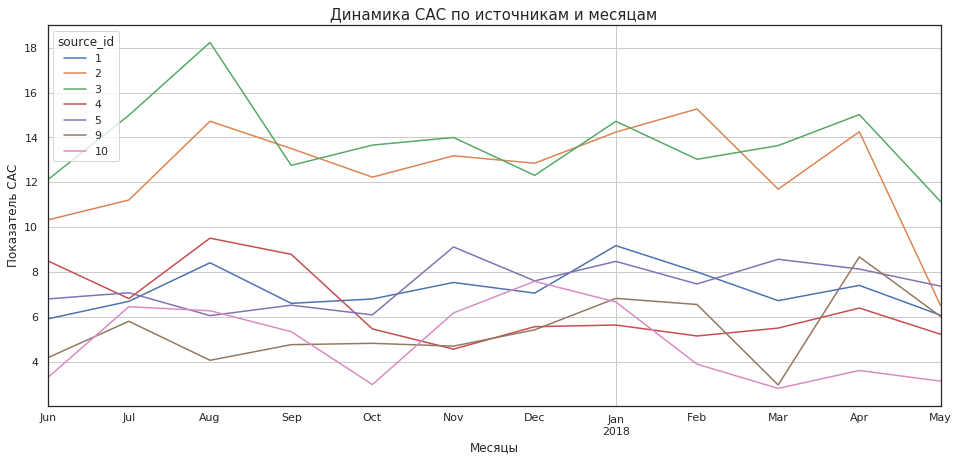

In [92]:
report_new.pivot_table(index='first_order_month', columns='source_id', values='cac', aggfunc='mean')\
.plot(figsize=(16,7), grid=True)
plt.title('Динамика CAC по источникам и месяцам', fontsize=15)
plt.xlabel('Месяцы', fontsize=12)
plt.ylabel('Показатель CAC', fontsize=12)
plt.show()

В целом по источникам 2 и 3 стоимость привлечения в течение года выше.

Рассмотрим ROI в разрезе источника и когорт.

In [93]:
def make_heatmap_plot(df, title, **kwargs):
    sns.set(style='white')
    plt.figure(figsize=(12,7))
    plt.title(title)
    sns.heatmap(df, annot=True, linewidths=1, linecolor='gray', **kwargs)
    plt.show()

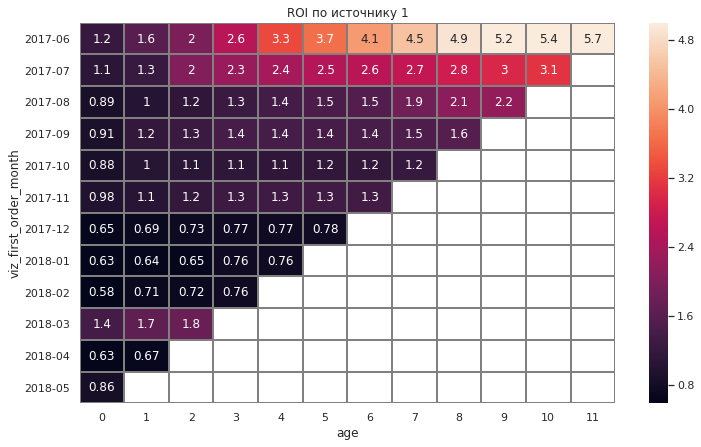

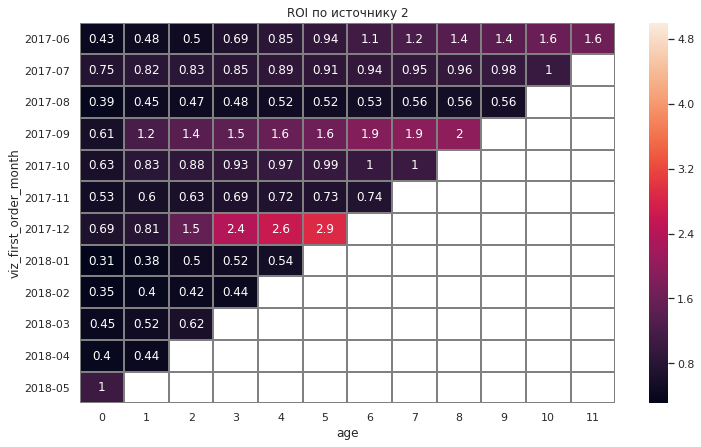

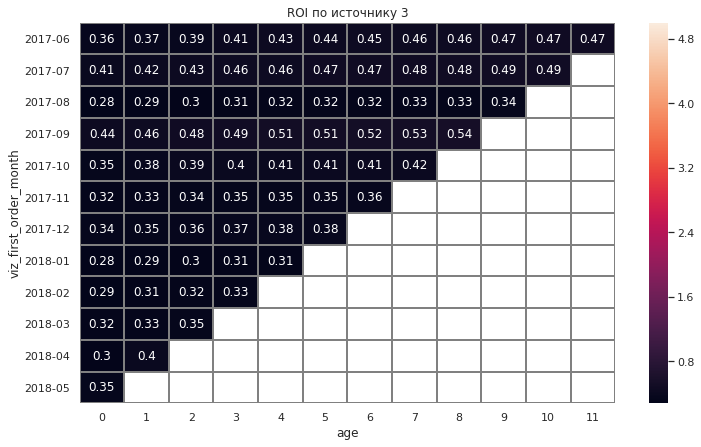

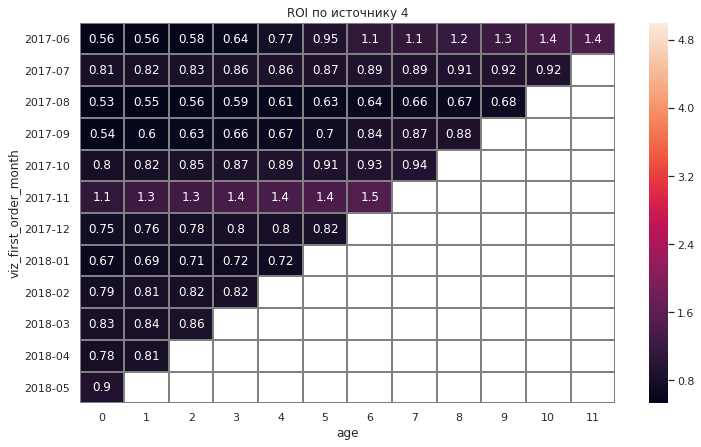

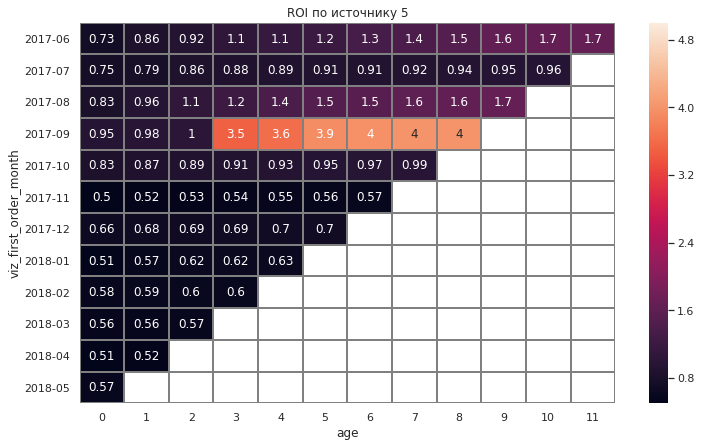

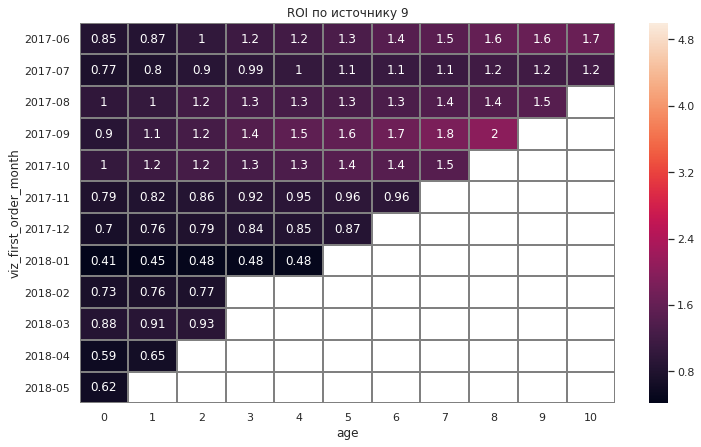

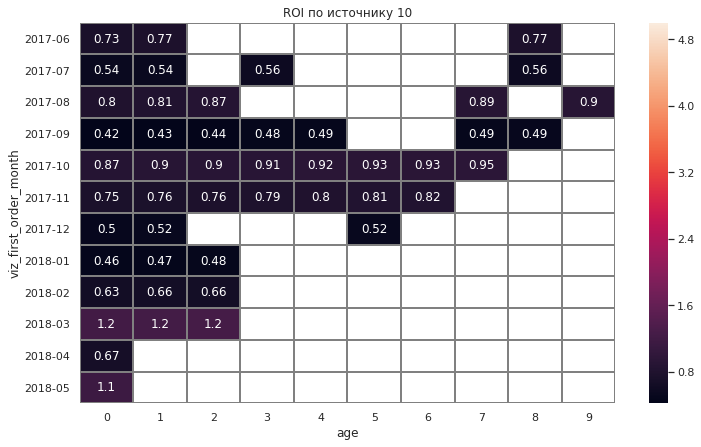

In [94]:
for source in report_new['source_id'].unique():
    tmp = report_new\
        .query("source_id==@source")\
        .assign(viz_first_order_month=lambda row: row['first_order_month'].dt.strftime('%Y-%m'))\
        .pivot_table(index='viz_first_order_month', columns='age', values='roi', aggfunc='sum').cumsum(axis=1)
    make_heatmap_plot(tmp, title=f'ROI по источнику {source}', vmax=5)

<hr style="border: 2px solid red;" />

Посмотрим на ROI 3-го источника: видим, что самый низкий показатель из всех. Положительно можем выделить летние когорты по источнику 1, декабрьскую по источнику 2 и сентябрьскую по источнику 5. По 10-му источнику видим пропуски: это значит, что не было заказов указанных когорт в конкретный месяц.

Посмотрим на среденее значение CAC.

In [95]:
report_new.groupby('source_id')['cac'].mean()

source_id
1      7.147620
2     12.639600
3     14.056894
4      6.980528
5      7.171887
9      5.059117
10     5.039289
Name: cac, dtype: float64

Также посмотрим на количество покупателей по источникам и на затраты по источникам.

In [96]:
report_new.groupby('source_id')['n_buyers'].sum()

source_id
1     17919
2     21042
3     63674
4     60217
5     44017
9      6743
10     5539
Name: n_buyers, dtype: int64

In [97]:
report_new.groupby('source_id')['costs'].sum()

source_id
1     127585.19
2     263847.09
3     868903.37
4     378008.44
5     317923.30
9      33240.98
10     24814.53
Name: costs, dtype: float64

### ШАГ 3. Вывод

Я порекомендую источник под номером 10. По нему меньше всего покупателей, но и меньше всего затрачено на рекламу. Его стоит попробовать масштабировать, так как он имеет самую низкую стоимость привлечения клиента, а показатель ROMI в среднем за год уступает лишь источнику 1.

Источники 2 и 3 оказались самыми затратными в плане стоимости привлечения клиентов. При этом ROMI по 3-му источнику самый низкий. Однако при этом 3-й источник привёл наибольшее количество покупателей - 63674. Значит, потенциал у него может быть и  есть, но стоит подумать о том, как можно оптимизировать рекламные кампании по этому источнику и снизить стоимость привлечения.

Также я бы порекомендовал источник под номером 1. По нему не так много покупателей (5-й показатель из всех), но он имеет самый высокий средний ROMI и не такую высокую стоимость привлечения клиента в сравнении с остальными источниками.

Кроме того, нужно присмотреться к источнику 4. Он привёл 60217 покупателей, уступая по стоимости привлечения только источникам 9 и 10 (по которым покупателей было в разы меньше). Здесь тоже можно поработать над оптимизацией рекламных компаний.